# Importing necessary libraries

In [72]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Recommendation System with LSH

## 1.1 Data Preparation

In [73]:
# Load the dataset for ratings and the one for movies
df_ratings = pd.read_csv("archive/rating.csv")
df_movies = pd.read_csv("archive/movie.csv")

# Merge them into a single df
main_df = pd.merge(df_ratings, df_movies, on="movieId")

In [ ]:
# view shape of df
main_df.shape 

(20000263, 6)

In [ ]:
 # check columns info and dtypes...
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [ ]:
# calculate statistical summary for numerical columns
main_df.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [ ]:
# summary for non numeric columns
main_df.describe(include='object')

,timestamp,title,genres
count,20000263,20000263,20000263
unique,15351121,26729,1329
top,1996-03-01 00:00:00,Pulp Fiction (1994),Drama
freq,643,67310,1467402


In [ ]:
# check df for null values
main_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [ ]:
# check df for duplicated rows
main_df.duplicated().sum()

0

In [74]:
# Check the number of unique users and movies
print(f"Number of unique users: {main_df['userId'].nunique()}")
print(f"Number of unique movies: {main_df['movieId'].nunique()}")


Number of unique users: 138493
Number of unique movies: 26744


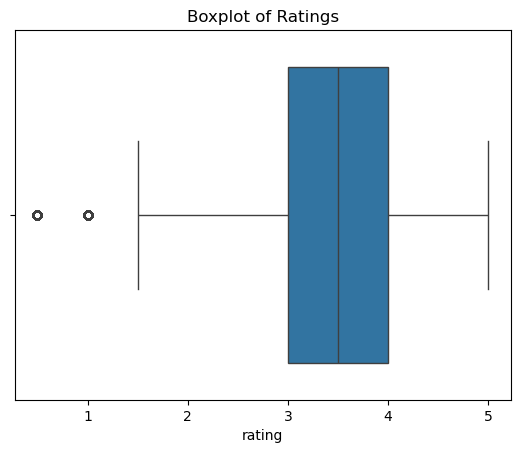

In [75]:
# check for outliers
sns.boxplot(x=main_df['rating'])
plt.title('Boxplot of Ratings')
plt.show()

# values around 1 are considered outliers, because probably not a lot of movies have a low rating


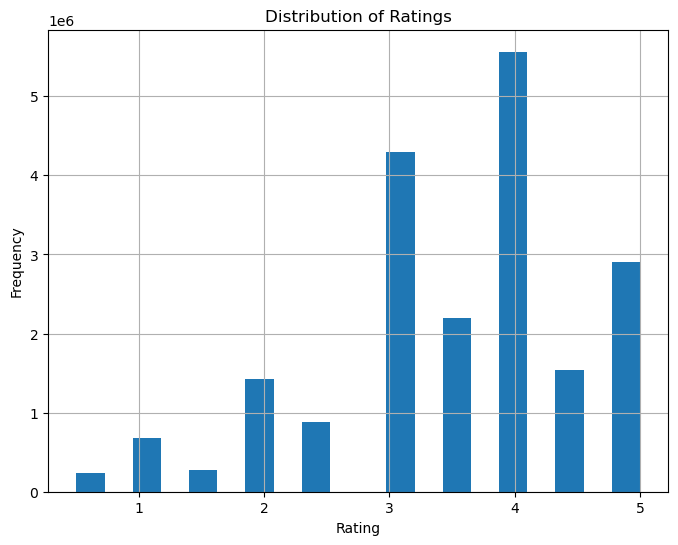

In [76]:
# Histogram to visualise the frequency of each rating score 
main_df['rating'].hist(bins=20, figsize=(8, 6))
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [77]:
# Check user activity (number of ratings per user)
user_activity = main_df['userId'].value_counts()
print(user_activity)

# Check movie popularity (number of ratings per movie)
movie_popularity = main_df['movieId'].value_counts()
print(movie_popularity)


userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
          ... 
89305       20
110463      20
96990       20
134747      20
6526        20
Name: count, Length: 138493, dtype: int64
movieId
296       67310
356       66172
318       63366
593       63299
480       59715
          ...  
125545        1
78873         1
112907        1
112909        1
110510        1
Name: count, Length: 26744, dtype: int64


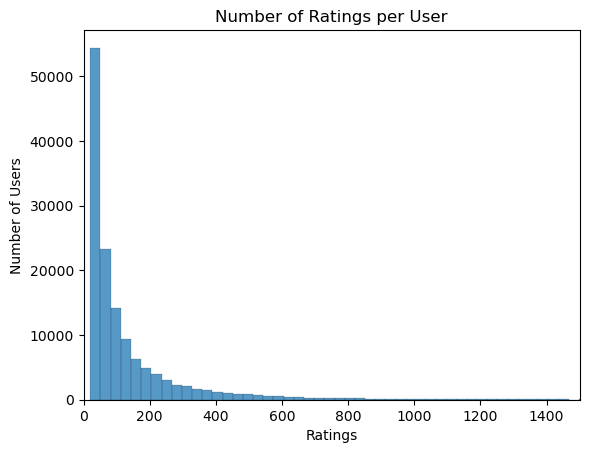

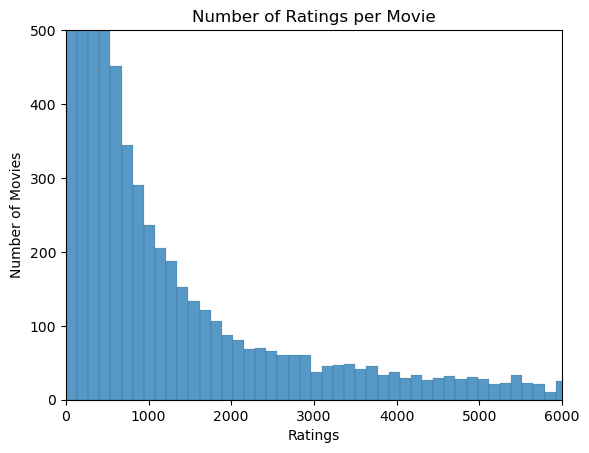

In [ ]:
# User activity visualised on graph
sns.histplot(user_activity, bins=300, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Ratings')
plt.ylabel('Number of Users')
plt.xlim(0, 1500)
plt.show()

# Movie popularity visualised on graph
sns.histplot(movie_popularity, bins=500, kde=False)
plt.title('Number of Ratings per Movie')
plt.xlabel('Ratings')
plt.ylabel('Number of Movies')
plt.xlim(0, 6000)
plt.ylim(0, 500)
plt.show()

In [78]:
# Handle the timestamp column converting it to datetime
main_df['timestamp'] = pd.to_datetime(main_df['timestamp']) 
print(df_ratings['timestamp'].head())

# checking dtype of timestamp column changed
main_df.info()

# not needed it until now...
''' 
# Extract useful time-based features (e.g., year, month)
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['second'] = df['timestamp'].dt.second
print(df.head())
'''


0    2005-04-02 23:53:47
1    2005-04-02 23:31:16
2    2005-04-02 23:33:39
3    2005-04-02 23:32:07
4    2005-04-02 23:29:40
Name: timestamp, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
 4   title      object        
 5   genres     object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 915.5+ MB


" \n# Extract useful time-based features (e.g., year, month)\ndf['year'] = df['timestamp'].dt.year\ndf['month'] = df['timestamp'].dt.month\ndf['day_of_week'] = df['timestamp'].dt.dayofweek\ndf['day'] = df['timestamp'].dt.day\ndf['hour'] = df['timestamp'].dt.hour\ndf['minute'] = df['timestamp'].dt.minute\ndf['second'] = df['timestamp'].dt.second\nprint(df.head())\n"

In [79]:
scaler = MinMaxScaler()

# Normalize the rating column using scaler
main_df['rating'] = scaler.fit_transform(main_df[['rating']])

# Check the result
main_df


,userId,movieId,rating,timestamp,title,genres
0,1,2,0.666667,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,0.666667,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,0.666667,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,0.666667,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,0.666667,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
20000258,138493,68954,0.888889,2009-11-13 15:42:00,Up (2009),Adventure|Animation|Children|Drama
20000259,138493,69526,0.888889,2009-12-03 18:31:48,Transformers: Revenge of the Fallen (2009),Action|Adventure|Sci-Fi|IMAX
20000260,138493,69644,0.555556,2009-12-07 18:10:57,Ice Age: Dawn of the Dinosaurs (2009),Action|Adventure|Animation|Children|Comedy|Rom...
20000261,138493,70286,1.000000,2009-11-13 15:42:24,District 9 (2009),Mystery|Sci-Fi|Thriller


## 1.2 Minhash Signatures